# xsar batch processing on datarmor (ifremer)

> unlike others examples, this notebook is not executed by the documentation module, so there are no output cells.

This notebook will show how to use `xsar` with `dask` to process many SAFEs, on datarmor.

We will see how to convert some L1 SAFEs files to L1B netcdf files at 1000m resolution. 

Basically, to use your own processing function, you will have to adapt the `l1b` function defined below.

## Prerequisite

This example is fully documented, and shoul be used by new users that have never used xsar or dask in a jupyter notebook on datarmor.


### Set up environment

We will assume that xsar is not installed, and dask is not configured for datarmor.

#### Get a node with internet access

This is needed, because `conda` need more cpu/ram than available on the submit node, and an internet access.

```
ssh datarmor
qsub -I -q ftp -l mem=16g,walltime=4:00:00
```

#### install environement


Install (and update) xsar. More infos on  https://cyclobs.ifremer.fr/static/sarwing_datarmor/xsar/installing.html

```
conda create -n xsar
conda activate xsar
conda install -c conda-forge xsar 'python<3.10'
pip install git+https://github.com/umr-lops/xsar.git
pip install -r https://raw.githubusercontent.com/umr-lops/xsar/develop/requirements.txt
pip install git+https://github.com/umr-lops/xsarsea.git
```

This is needed for coastlines, because datarmor nodes don't have internet access

```
cartopy_feature_download.py --output `python -c 'import cartopy ; print(cartopy.config["data_dir"])'` physical
```

This is needed for https://datarmor-jupyterhub.ifremer.fr/

```
conda install -c conda-forge jupyterhub
python -m ipykernel install --user
```


Install https://dask-hpcconfig.readthedocs.io/en/latest/

```
pip install git+https://github.com/umr-lops/dask-hpcconfig.git#egg=dask-hpcconfig
```

Enable dask-labextension, so the dask dashboard can be reached

```
pip install dask-labextension
pip install ipywidgets
```

### download and execute this notebook

Now , go to https://datarmor-jupyterhub.ifremer.fr, and choose 'jupyter lab'. Put 'xar' in the optionnal field, to use the previously created env.

It better to use a 8Gb ram notebook or more to handle the dask scheduler.

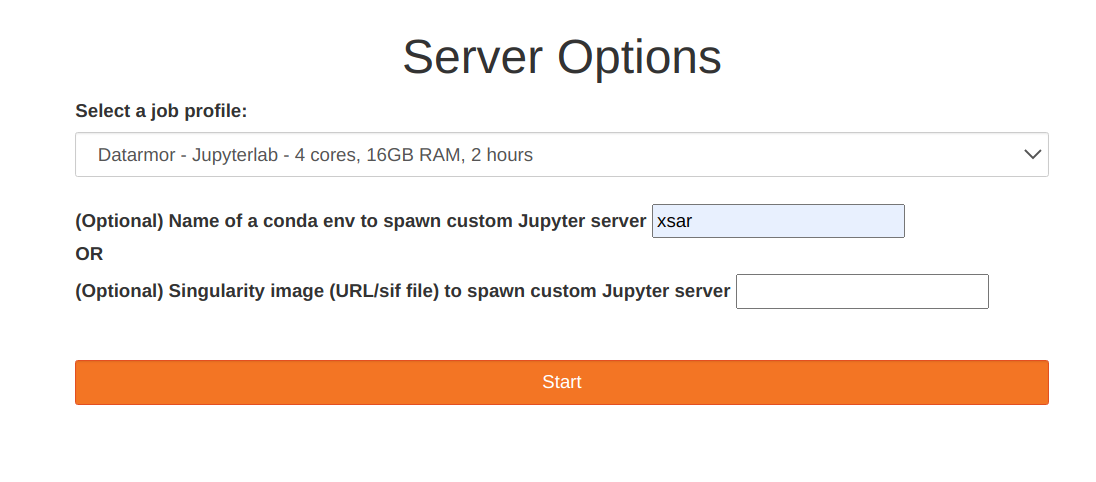

Dowlnoad this notebook as ipynb, and open it jupyterhub. 
You are now ready to execute it.

In [ ]:
import xsar
import distributed
import dask_hpcconfig
import glob
import pandas as pd
import os
import dask.dataframe as dd
import time
from tqdm.auto import tqdm, trange
import numpy as np
import traceback

## Get input and outputs as rows of a pandas dataframe

The first step is to build a `pandas.Dataframe` with input SAFEs and output paths. Basicallys, eachs rows will be fed to our processing function, in parallel.

Elements size should be small, like filenames or very small python objects. Do not use here complex datatypes like `xsar.Sentinel1Meta` objects, or numpy array. (However, it's possible to use dask futures).

It's important to be able to know if the processing is allready done, because we wan't to be able to skip what's allready done. 

It's a good practice to do that before calling the processing function, and a bad practice to do than *inside* the processing function, because a processing slot will be used on a worker to do nothing.

In [ ]:
# get input SAFEs, as a pandas dataframe
df_safes = pd.DataFrame(glob.glob('/home/datawork-cersat-public/cache/project/mpc-sentinel1/data/esa/sentinel-1a/L1/IW/S1A_IW_GRDH_1S/2021/12*/*.SAFE'), columns=['safe'])
# we just add an invalid SAFE, to be able to handle errors
df_safes.loc[-1,'safe'] = 'error.SAFE'
df_safes

In [ ]:
# compute out_path
out_path_prefix = '%s/xsar_dask_demo' % os.environ['SCRATCH']
os.makedirs(out_path_prefix, exist_ok=True)
df_safes['out_path'] = df_safes['safe'].apply(lambda f: '%s/%s.nc' % (out_path_prefix, os.path.splitext(os.path.basename(f))[0]))
df_safes

In [ ]:
# filter out_path that allready exists
df_safes = df_safes[df_safes['out_path'].apply(lambda f: not os.path.exists(f))]
df_safes

## Main processing function

the `l1b` function is the main processing function. It should take very small arguments size, like input file and output file. Do not use arguments with big size here (like xarray or complex objects)

In this example, we just open the safe at 1000m resolution, and save it as a netcdf file.

This is the function you will need to change for your own processing.

In [ ]:
def l1b(safe, outfile):
    ds = xsar.open_dataset(safe, resolution='1000m')['measurement'].ds
    # make attributes to be str, so writable to file
    to_str = ['start_date', 'stop_date', 'footprint']
    for attr in to_str:
        ds.attrs[attr] = str(ds.attrs[attr])
    ds.to_netcdf(outfile)
    return outfile

To process all SAFEs from `df_safes`, what we don't want to do is to use a sequential loop like

```python
for idx, safe in df_safes.iterrows():
    print(l1b(*safe))
```

Because the processing whould be sequential (one safe is processed at a time), and it can take a long time.

So what we want to do is to use dask to execute many `l1b` function in parallel.

## set up the dask cluster

We use [dask-hpcconfig](https://dask-hpcconfig.readthedocs.io/en/latest/). See the doc to set up a different cluster.

In [ ]:
# see https://dask-hpcconfig.readthedocs.io/en/latest/ if you want to change the cluster config
override = {
    "cluster.n_workers": 28, 
    "cluster.cores": 1,
    "cluster.extra": ["--lifetime", "30m", "--lifetime-stagger", "10m", "--lifetime-restart" ] # restart worker to clean state periodicaly
}
cluster = dask_hpcconfig.cluster('datarmor' , **override)
cluster.scale(4)
client = distributed.Client(cluster)
client

If you click the above dashboard link, you should reach the dask status page that look like this:

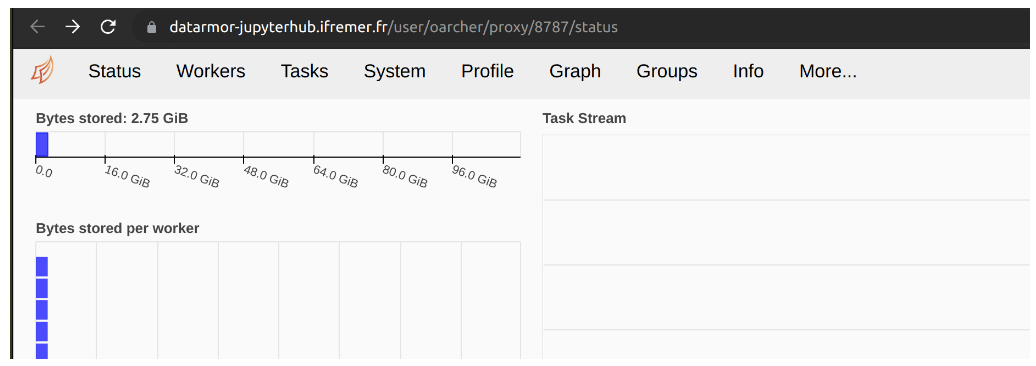

From now, the interresing parts are the 'workers' tab and the 'info' tab.

### workers tab
the workers tab should be something like

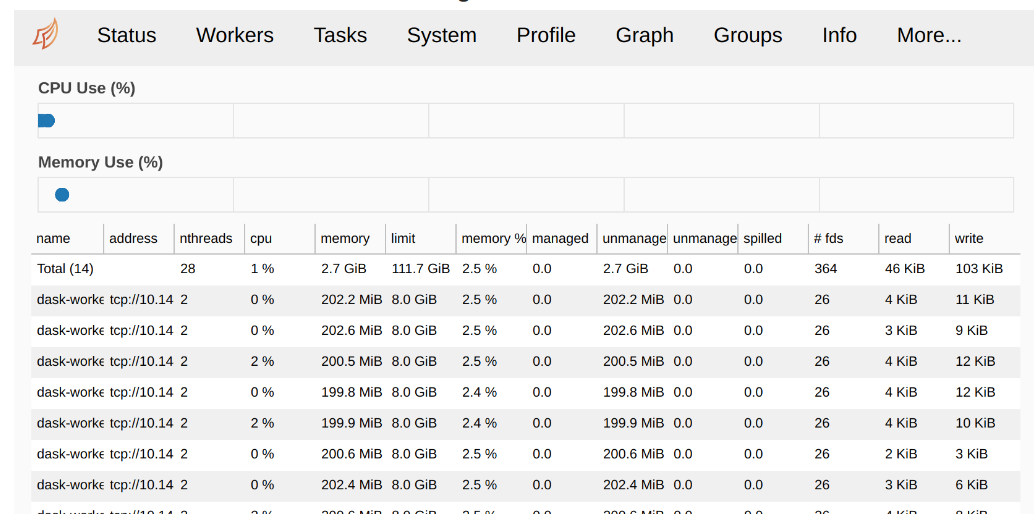

If it's empty, the cluster is not allready instanciated (execute the cell bellow to wait for it)

### info tab
The info tab should be something like

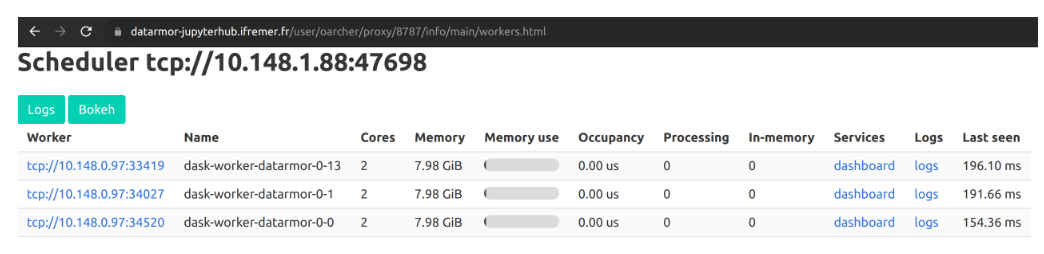

What's important here is the 'last seen' column. It should be above '1s'


## waiting for the cluster to be operationnal

This should probably not needed, but we want to be sure that the cluster is ok.

The main problem is that the `check` function that just do `import xsar` can be very long (up to 8 minutes).
The issue is partialy solved by https://github.com/umr-lops/xsar/issues/65 , but it's probably due to a datarmor IO problem.

The cluster should be up in 15s-60s, and the `import xsar` should take 30s-400s.

The `import xsar` sometimes freeze the worker (probably because the GIL is not released). This can be show in the 'last seen' column of the 'info' tab as seen above. (If it's greater than 60s, the tab should turn red).

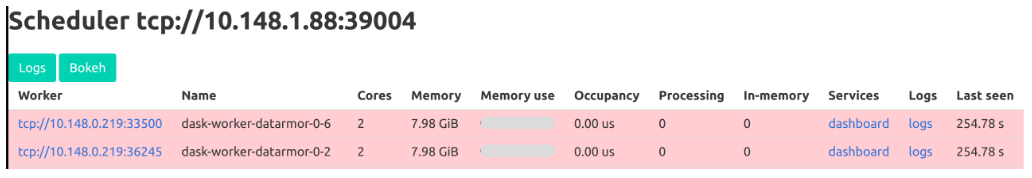

In [ ]:
while len(client.scheduler_info()['workers']) == 0:
    print('waiting for cluster')
    time.sleep(5)
print('cluster is up. checking `import xsar`')

def check():
    import xsar
    return True
t0 = time.time()
client.run(check)
print('client checked in %d s' % (time.time() - t0 ))

## Split df_safes into smaller parts

So we have `df_safes` that is a `pandas.Dataframe` object, with all SAFEs to be processed.

We want to split this dataframe in smaller parts, and process those parts in parallel on different workers.

To to so, we use `dask.dataframe`.

In [ ]:
# we build a dask dataframe, with npartitions, so npartitions safes will be processed in parallel
# npartitions depend on your processing and the workers count
# a good starting value is to use the same number as the workers count
# with heavy full res processing you will have to reduce it
ddf_safes = dd.from_pandas(df_safes, npartitions=14)
ddf_safes

## the batch processing function

The `batch_processing` function will we executed on the workers. There will be as many `batch_processing` functions running in paralell as `npartitions`.

Each functions will be fed with a partition of `ddf_safes`. A partition is a regular `pandas.Dataframe` object like `df_safes`, but with fewer rows.

Basically, a minimal `batch_processing` function should look like this:

```python
def batch_processing(df_safes_part):
    for _, safe_row in df_safes_part.iterrows():
        safe, outfile = safe_row[['safe', 'out_path']]
        l1b(safe, outfile)
```

the disadvantage of this method are:

  * If the worker restart, and the function is retried, allready processed file will be reprocessed.
  
So we need to test if the outfile file exists before calling `l1b`

  * Errors are not catched. If a `l1b` processing fail, remainings rows will be not processed.
  
We just need to surround the `l1b` call with a `try/except` block

  * Errors messages are hidden in the workers logs
  
If a `l1b` processing fail, we need to know the error cause, and send it to the notebook.

To be able to to that, we will use a `distributed.Queue` object, and will use it to send processing infos and error messages, as a dict like
```
{
    'status': False,
    'args': (safe, outfile),
    'time': 0,
    'error': ""
}
```

  



In [ ]:
# we set up a dask queue, so the batch_processing function, will be able to communicate processing infos to the notebook
messages_queue = distributed.Queue('batch_processing')

def batch_processing(df_safes_part, msg_queue=messages_queue):
    res = []
    for idx, safe_row in df_safes_part.iterrows():
        safe, outfile = safe_row[['safe', 'out_path']]
        # we need to re-check if outfile allready exist, because dask might have restarted the worker
        # and we don't want the whole df_safes to be reprocessed
        if os.path.exists(outfile):
            res.append(outfile)
            continue
        
        # we set up a dict that we will send to msg_queue 
        # it contains general processing info
        message = {
            'status': False,
            'args': (safe, outfile),
            'time': 0,
            'error': ""
        }
        
        # if a processing fail, we will retry
        for retry in range(2):
            # we enclose the processing in a try/except, so the worker won't be killed if error
            try:
                t1 = time.time()
                # this is the real call to our processing function
                out = l1b(safe, outfile)
                elapsed = time.time() - t1
                message['status'] = True
                message['time'] = elapsed 
                break # process ok, exit the loop
            except Exception as e:
                # error while processing.
                # we get the error message that will be sent to the queue
                message['error'] = traceback.format_exc()
        msg_queue.put(message)
        res.append(outfile)
    return res
            
    

## launch the distributed computation

Now, we want to apply the `batch_processing` function to each partition of `dd_safes`.

We use the `map_partitions` method. We use use a dummy `meta` keyword. What's important here is `str` (the output type of the `l1b` function).

In [ ]:
res = ddf_safes.map_partitions(batch_processing, meta=('foo', str))

At this stage, the computation has not yet started.

One way to to it should be:

```python
res.compute()
```

But we won't be able to see messages from `messages_queue` and we won't see any progress information.

we will instead use 
```
res.persist()
```

and build a progress bar with `tqdm` that will wait for messages from `messages_queue`, and display status information.


In [ ]:

res.persist(retries=1)

count = len(ddf_safes)

pbar = trange(count,smoothing=0)
elapsed = np.array([],dtype=float)
for _ in pbar:
    message = messages_queue.get()
    if message['status']:
        elapsed = np.append(elapsed,message['time'])
        pbar.set_description('%03.0fs' % elapsed.mean())
    else:
        tqdm.write('ERROR: "\n%s\n" on args %s' % ( message['error'] , message['args']))

While processing occur, you should seel a progressbar like this:

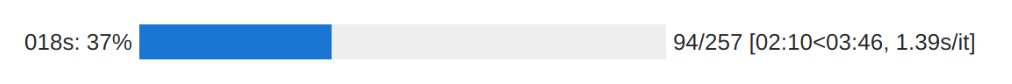

18s is the mean time to process one SAFE, per worker. But as we have many workers, an new SAFE is processed every 1.39s.

We have inserted an invalid 'error.SAFE' file. The error traceback should be displayed.

While processing, the dask status dashboard should look like this:
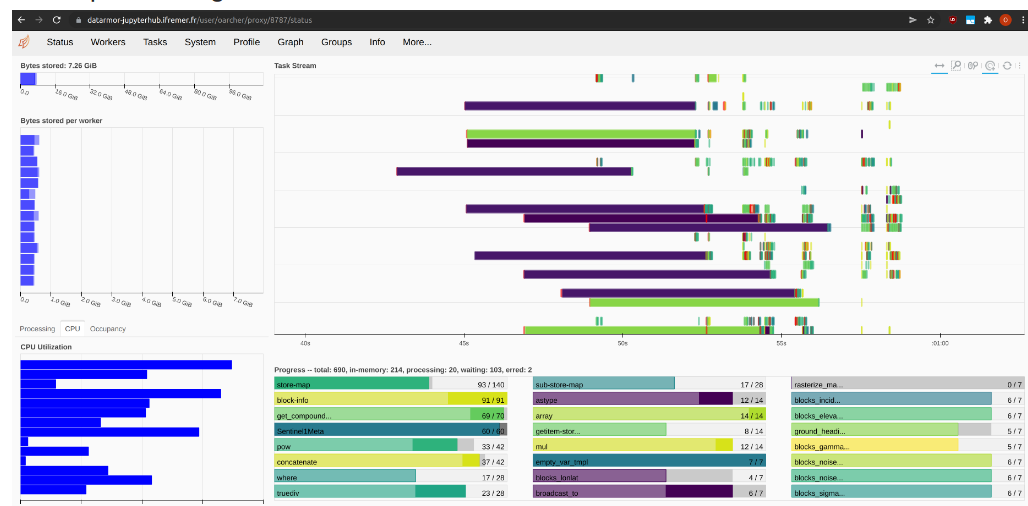


## End

Once the processing is finished, processed files are in the output directory.

We can now close the cluster.


In [ ]:
cluster.close()
client.close()